In [18]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from itertools import product
from typing import Dict, List, Any
from math import inf

In [19]:
# Load dataset
climate_df: pd.DataFrame = pd.read_csv("../data/Cleaned_Data_Seasonal.csv")
climate_df.head()

,Region,Year,Season,ACI_Combined_Seasonal_Smoothed,ACI_Combined_Seasonal_Unsmoothed,CDD_Seasonal_Smoothed,CDD_Seasonal_Unsmoothed,CDD_Seasonal_Unsmoothed_Unstandardized,Rx5Day_Seasonal_Smoothed,Rx5Day_Seasonal_Unsmoothed,...,Sea_Level_Seasonal_Unsmoothed_Unstandardized,T10_Seasonal_Smoothed,T10_Seasonal_Unsmoothed,T10_Seasonal_Unsmoothed_Unstandardized,T90_Seasonal_Smoothed,T90_Seasonal_Unsmoothed,T90_Seasonal_Unsmoothed_Unstandardized,WP90_Seasonal_Smoothed,WP90_Seasonal_Unsmoothed,WP90_Seasonal_Unsmoothed_Unstandardized
0,ALA,1961,1,0.24,0.58,0.13,-0.26,33.96,0.01,-0.57,...,7266.74,0.05,-1.51,1.31,-0.11,0.42,13.04,0.14,0.62,11.51
1,CAR,1961,1,-0.12,0.32,NaN,NaN,NaN,0.08,0.87,...,NaN,0.10,-0.98,5.47,-0.30,-0.12,10.12,-0.18,-0.47,8.62
2,CEA,1961,1,-0.31,-0.80,-0.18,-1.01,14.93,-0.17,-0.33,...,6917.55,0.09,1.19,15.88,-0.10,-0.41,8.26,-0.44,-1.05,7.18
3,CWP,1961,1,0.06,0.33,0.44,0.75,50.62,-0.49,-0.82,...,7126.53,-0.27,-1.29,2.70,0.06,0.79,13.28,-0.10,-0.27,9.00
4,MID,1961,1,0.05,-0.25,0.76,-0.47,22.53,-0.14,-1.01,...,NaN,-0.15,-0.65,6.86,-0.15,0.49,11.98,-0.34,-0.92,7.69


In [20]:
# Aggregate data by year using min, max, and mean aggregations
adjusted_climate_df: pd.DataFrame = climate_df.groupby(["Year", "Region"]).agg({
    "CDD_Seasonal_Smoothed": ["mean"],
    "Sea_Level_Seasonal_Smoothed": ["mean", "min", "max"],
    "T90_Seasonal_Smoothed": ["mean", "min", "max"],
    "T10_Seasonal_Smoothed": ["mean", "min", "max"],
    "WP90_Seasonal_Smoothed": ["mean", "min", "max"]
}).reset_index()

adjusted_climate_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in adjusted_climate_df.columns.values]

adjusted_climate_df.head()

,Year,Region,CDD_Seasonal_Smoothed_mean,Sea_Level_Seasonal_Smoothed_mean,Sea_Level_Seasonal_Smoothed_min,Sea_Level_Seasonal_Smoothed_max,T90_Seasonal_Smoothed_mean,T90_Seasonal_Smoothed_min,T90_Seasonal_Smoothed_max,T10_Seasonal_Smoothed_mean,T10_Seasonal_Smoothed_min,T10_Seasonal_Smoothed_max,WP90_Seasonal_Smoothed_mean,WP90_Seasonal_Smoothed_min,WP90_Seasonal_Smoothed_max
0,1961,ALA,0.1950,1.3625,1.34,1.38,-0.1200,-0.14,-0.11,0.0125,-0.09,0.05,0.0925,0.04,0.14
1,1961,CAN,0.4250,-0.0950,-0.10,-0.09,-0.1400,-0.23,-0.06,-0.1275,-0.21,-0.03,0.4425,0.42,0.49
2,1961,CAR,NaN,NaN,NaN,NaN,-0.2625,-0.30,-0.20,0.0950,0.05,0.16,-0.2075,-0.22,-0.18
3,1961,CEA,-0.2325,-0.8550,-0.89,-0.82,-0.0525,-0.10,0.06,-0.0500,-0.20,0.09,-0.4175,-0.44,-0.36
4,1961,CWP,0.4600,0.2250,0.20,0.24,0.1100,0.03,0.18,-0.3650,-0.46,-0.27,-0.0775,-0.15,-0.01


In [21]:
# Drop empty records
print(f"Records before dropping empty rows: {len(adjusted_climate_df)}")
adjusted_climate_df = adjusted_climate_df.dropna()
print(f"Records after dropping empty rows: {len(adjusted_climate_df)}")

Records before dropping empty rows: 1071
Records after dropping empty rows: 819


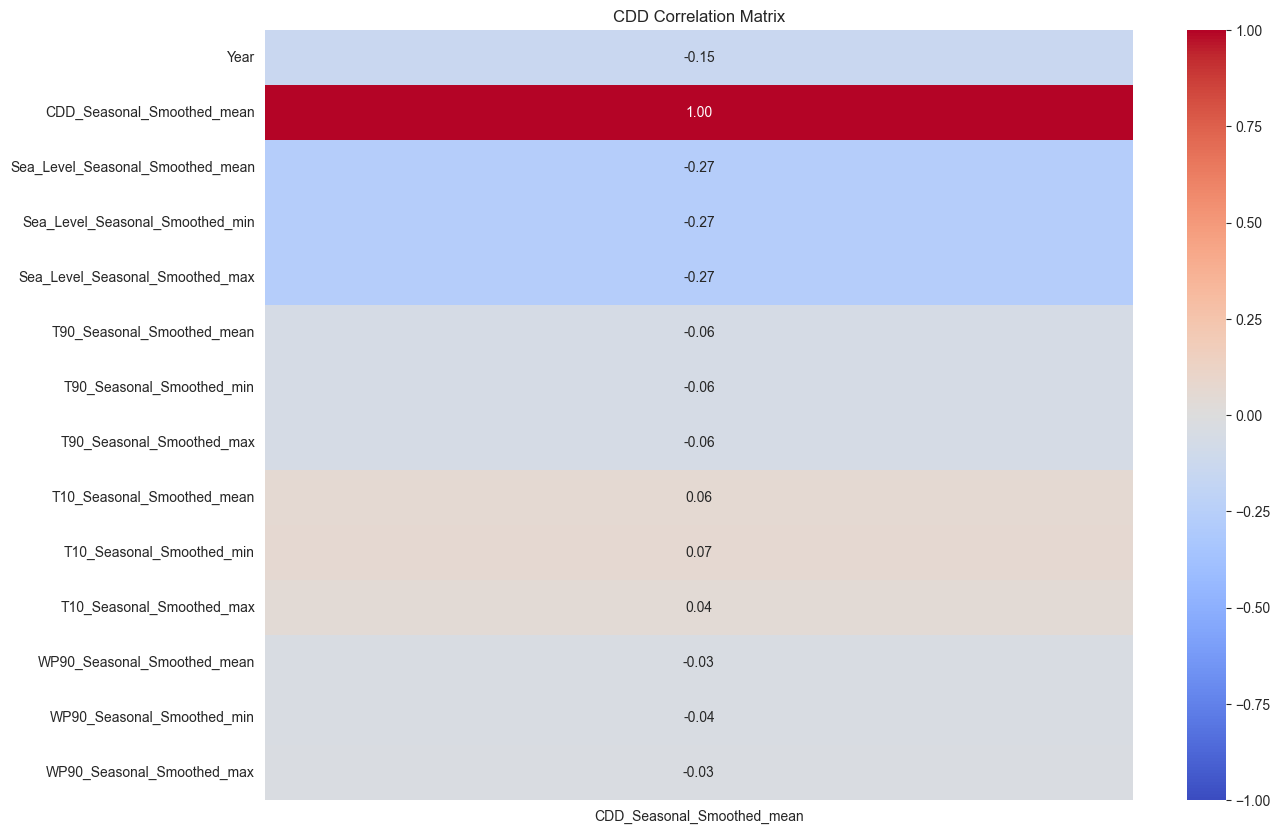

In [22]:
# Create correlation matrix
correlation_matrix = adjusted_climate_df.corr(numeric_only=True)[["CDD_Seasonal_Smoothed_mean"]]
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True)
plt.title('CDD Correlation Matrix')
plt.show()

In [23]:
# Encode region as collection of boolean dummy variables
region_dummies = pd.get_dummies(adjusted_climate_df["Region"], prefix="Region")
base_features = pd.concat([adjusted_climate_df["Year"], region_dummies], axis=1)
base_features.head()

,Year,Region_ALA,Region_CAN,Region_CEA,Region_CWP,Region_NEA,Region_NEF,Region_NPL,Region_NWP,Region_SEA,Region_SPL,Region_SWP,Region_USA,Region_USC
0,1961,True,False,False,False,False,False,False,False,False,False,False,False,False
1,1961,False,True,False,False,False,False,False,False,False,False,False,False,False
3,1961,False,False,True,False,False,False,False,False,False,False,False,False,False
4,1961,False,False,False,True,False,False,False,False,False,False,False,False,False
6,1961,False,False,False,False,True,False,False,False,False,False,False,False,False


In [24]:
# Function to train linear regression model based on provided features and target data
def build_linear_regression_model(feature_df: pd.DataFrame, target_df: pd.Series):
    x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.3, random_state=1)
    x_train_const: pd.DataFrame = sm.add_constant(x_train)
    return sm.OLS(y_train, x_train_const.astype(float)).fit(), x_test, y_test

In [25]:
# Train base linear regression model
target: pd.Series = adjusted_climate_df["CDD_Seasonal_Smoothed_mean"]

model, x_test, y_test = build_linear_regression_model(base_features, target)
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     CDD_Seasonal_Smoothed_mean   R-squared:                       0.105
Model:                                    OLS   Adj. R-squared:                  0.084
Method:                         Least Squares   F-statistic:                     5.018
Date:                        Thu, 22 Feb 2024   Prob (F-statistic):           2.03e-08
Time:                                20:38:56   Log-Likelihood:                -521.50
No. Observations:                         573   AIC:                             1071.
Df Residuals:                             559   BIC:                             1132.
Df Model:                                  13                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [26]:
# Function to test linear regression model
def run_prediction(predictive_model, x_test_df: pd.DataFrame, y_test_df: pd.DataFrame):
    x_test_const: pd.DataFrame = sm.add_constant(x_test_df)
    y_prediction = predictive_model.predict(x_test_const)
    mse = mean_squared_error(y_test_df, y_prediction)
    r_squared = r2_score(y_test_df, y_prediction)
    
    print(f"The test data MSE is {round(mse, 3)}.")
    print(f"The test data r-squared value is {round(r_squared, 3)}.")
    return y_prediction

In [27]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.381.
The test data r-squared value is -0.003.


In [28]:
# Function to scatterplot model predictions against actual values
def plot_actual_vs_predicted(actuals, predictions):
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.title('Actual vs. Predicted CDD Values')
    plt.xlabel('Actual CDD')
    plt.ylabel('Predicted CDD')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2) 
    plt.grid(True)
    plt.show()

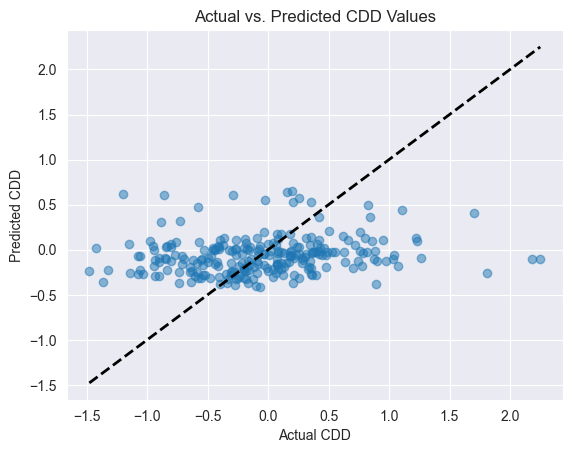

In [29]:
plot_actual_vs_predicted(y_test, y_predictions)

In [30]:
# Train linear regression model with sea level
sea_level_features: pd.DataFrame = pd.concat([base_features, adjusted_climate_df["Sea_Level_Seasonal_Smoothed_mean"]], axis=1)

model, x_test, y_test = build_linear_regression_model(sea_level_features, target)
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     CDD_Seasonal_Smoothed_mean   R-squared:                       0.154
Model:                                    OLS   Adj. R-squared:                  0.133
Method:                         Least Squares   F-statistic:                     7.273
Date:                        Thu, 22 Feb 2024   Prob (F-statistic):           5.29e-14
Time:                                20:38:57   Log-Likelihood:                -505.11
No. Observations:                         573   AIC:                             1040.
Df Residuals:                             558   BIC:                             1105.
Df Model:                                  14                                         
Covariance Type:                    nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [31]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.378.
The test data r-squared value is 0.006.


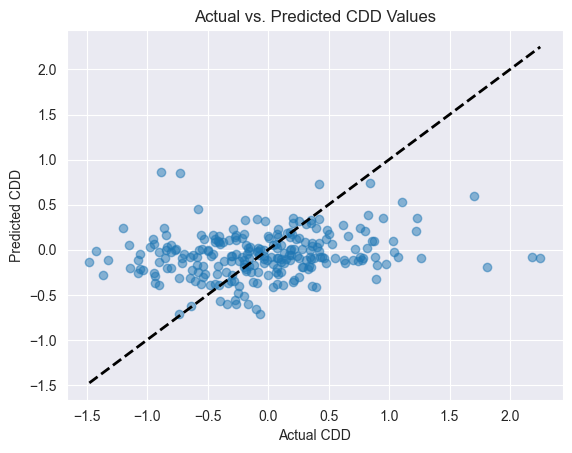

In [32]:
plot_actual_vs_predicted(y_test, y_predictions)

In [33]:
# Functions for hyperparameter optimization
def generate_hyperparameters(params: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    keys = list(params.keys())
    values_product = product(*params.values())
    combinations = [{keys[i]: value for i, value in enumerate(values)} for values in values_product]
    return combinations

def find_optimal_hyperparameters(model_class, hyperparameters: List[Dict[str, Any]], features_df, target_series) -> Dict[str, Any]:
    x_train, x_test, y_train, y_test = train_test_split(features_df, target_series, test_size=0.3, random_state=1)
    
    min_mse = inf
    best_hyperparameters = None
    for hyperparameterSet in hyperparameters:
        model_instance = model_class(**hyperparameterSet, random_state=1)
        model_instance.fit(x_train, y_train)
        model_y_prediction = model_instance.predict(x_test)
        model_mse = mean_squared_error(y_test, model_y_prediction)
        
        if model_mse < min_mse:
            min_mse = model_mse
            best_hyperparameters = hyperparameterSet
            
    return best_hyperparameters

In [34]:
# Optimize decision tree hyperparameters
optimized_hyperparameters = find_optimal_hyperparameters(DecisionTreeRegressor, generate_hyperparameters({"max_depth": list(range(1, 21))}), sea_level_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 18}


In [35]:
# Train decision tree model
x_train, x_test, y_train, y_test = train_test_split(sea_level_features, target, test_size=0.3, random_state=1)
dt_regressor = DecisionTreeRegressor(**optimized_hyperparameters, random_state=1)
dt_regressor.fit(x_train, y_train)

y_predictions = dt_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.2.
The test data r-squared value is 0.474.


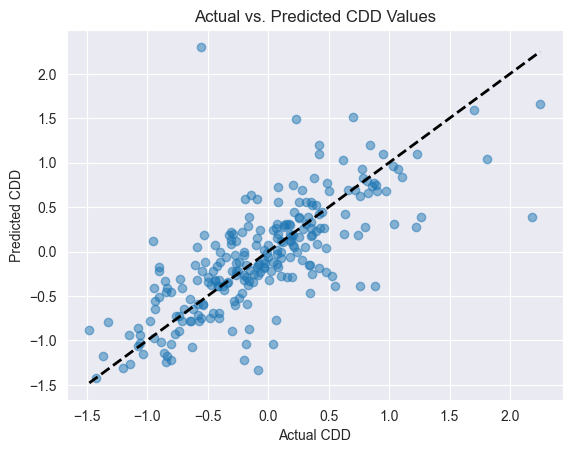

In [36]:
plot_actual_vs_predicted(y_test, y_predictions)

In [37]:
# Optimize random forest hyperparameters
optimized_hyperparameters = find_optimal_hyperparameters(RandomForestRegressor, generate_hyperparameters({"max_depth": list(range(1, 21)), "n_estimators": range(10, 151, 10)}), sea_level_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 15, 'n_estimators': 40}


In [38]:
# Train and test random forest model
x_train, x_test, y_train, y_test = train_test_split(sea_level_features, target, test_size=0.3, random_state=1)
rf_regressor = RandomForestRegressor(**optimized_hyperparameters, random_state=1)
rf_regressor.fit(x_train, y_train)

y_predictions = rf_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.106.
The test data r-squared value is 0.722.


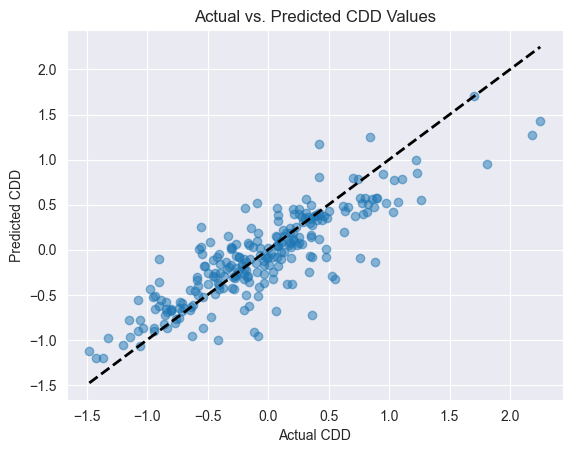

In [39]:
plot_actual_vs_predicted(y_test, y_predictions)

In [40]:
# Run random forest feature importance test
feature_importances = rf_regressor.feature_importances_
feature_names = sea_level_features.columns
features_and_importances = zip(feature_names, feature_importances)
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")

Year: 0.42171023152770454
Sea_Level_Seasonal_Smoothed_mean: 0.4004522450023664
Region_SEA: 0.028734412135539563
Region_ALA: 0.021657600219302322
Region_NEA: 0.019583141566631834
Region_NPL: 0.015554325301191088
Region_CEA: 0.01404950087792708
Region_NEF: 0.012517558909295658
Region_CAN: 0.012217833057786957
Region_SWP: 0.011191465714885301
Region_USC: 0.010556300505300568
Region_CWP: 0.009469669942107252
Region_NWP: 0.008275227284225063
Region_USA: 0.007685530650386411
Region_SPL: 0.006344957305350111


In [41]:
# Run permutation test for feature importance
result = permutation_importance(rf_regressor, x_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)
sorted_importances_idx = result.importances_mean.argsort()
for idx in sorted_importances_idx[::-1]:  # Reverse order to display the most important first
    print(f"{x_test.columns[idx]}: {result.importances_mean[idx]:.5f} ± {result.importances_std[idx]:.5f}")

Year: 1.16334 ± 0.08640
Sea_Level_Seasonal_Smoothed_mean: 0.58913 ± 0.08839
Region_SEA: 0.10792 ± 0.01079
Region_NEA: 0.05459 ± 0.01149
Region_SWP: 0.02201 ± 0.00380
Region_ALA: 0.02091 ± 0.00435
Region_NWP: 0.01894 ± 0.00226
Region_USC: 0.01674 ± 0.00285
Region_CAN: 0.01649 ± 0.00349
Region_NEF: 0.01213 ± 0.00304
Region_CEA: 0.01209 ± 0.00575
Region_NPL: 0.00910 ± 0.00262
Region_CWP: 0.00371 ± 0.00178
Region_USA: 0.00363 ± 0.00133
Region_SPL: 0.00133 ± 0.00098
